# Модель 19

#### Импорт необходимых библиотек

In [1]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
num_model = '_g_19'

#### Аугментация (4)

In [3]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Скачиваем датасеты

In [4]:
train_ds, val_ds, test_ds = get_ds(
    'smote_data_train_7000', 'repaired_data_test', val_size=0.12,
    transform=transformer, one_hot=True, back=2, batch_size=100
)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [5]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

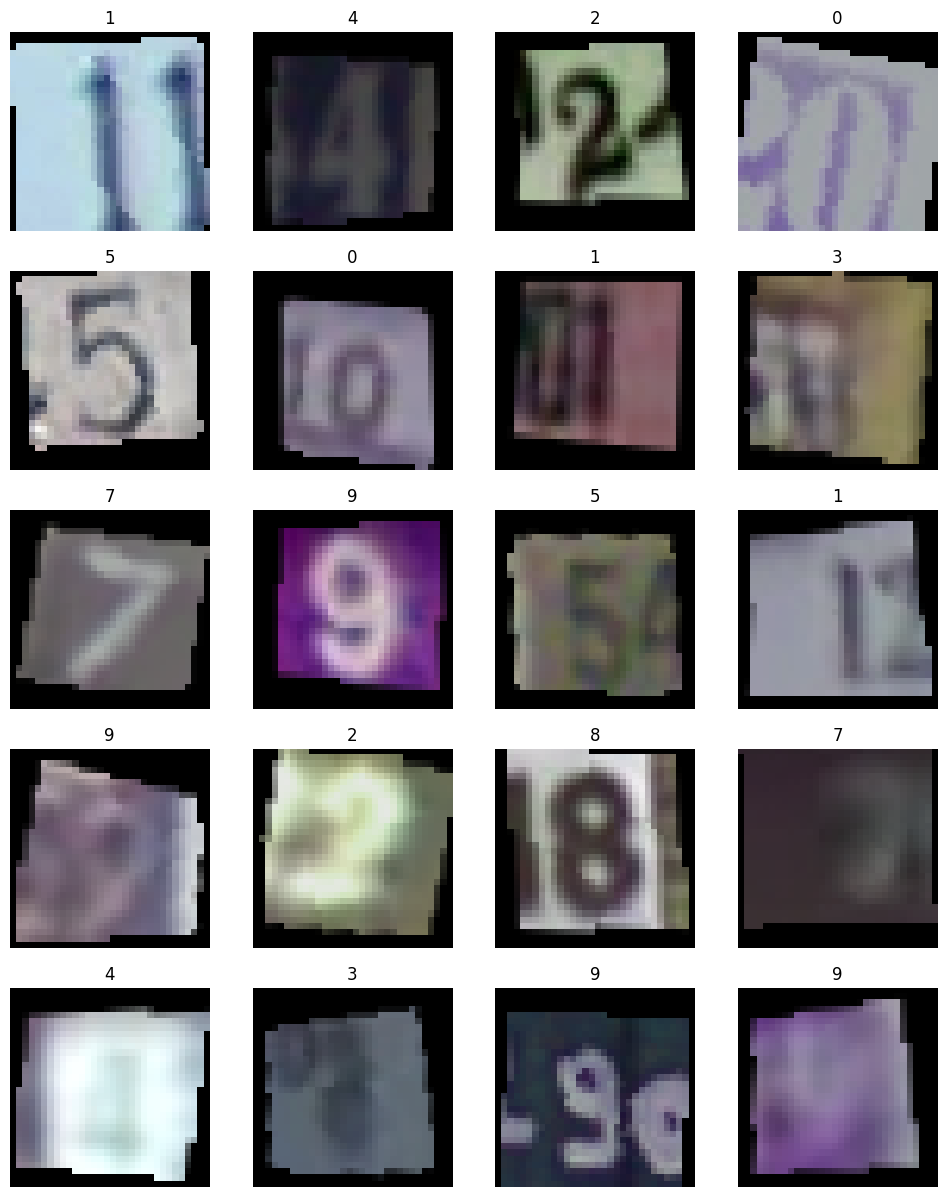

In [6]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель

Мылси о моделе: 
- Постараюсь написать просто максимально упрощеный resnet

In [7]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3), batch_size=100),
    tf.keras.layers.Conv2D(32, 5, bias_regularizer='l2'),
    tf.keras.layers.Conv2D(32, 3, bias_regularizer='l2'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, bias_regularizer='l2'),
    tf.keras.layers.Conv2D(64, 3, bias_regularizer='l2'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', bias_regularizer='l2'),
    tf.keras.layers.Conv2D(128, 3, padding='same', bias_regularizer='l2'),
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (100, 28, 28, 32)         2432      
                                                                 
 conv2d_1 (Conv2D)           (100, 26, 26, 32)         9248      
                                                                 
 max_pooling2d (MaxPooling2D  (100, 13, 13, 32)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (100, 11, 11, 64)         18496     
                                                                 
 conv2d_3 (Conv2D)           (100, 9, 9, 64)           36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (100, 4, 4, 64)          0         
 2D)                                                    

#### Создаем чекпоинты

In [8]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели

In [9]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.03)


callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

In [10]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(0.0016)),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

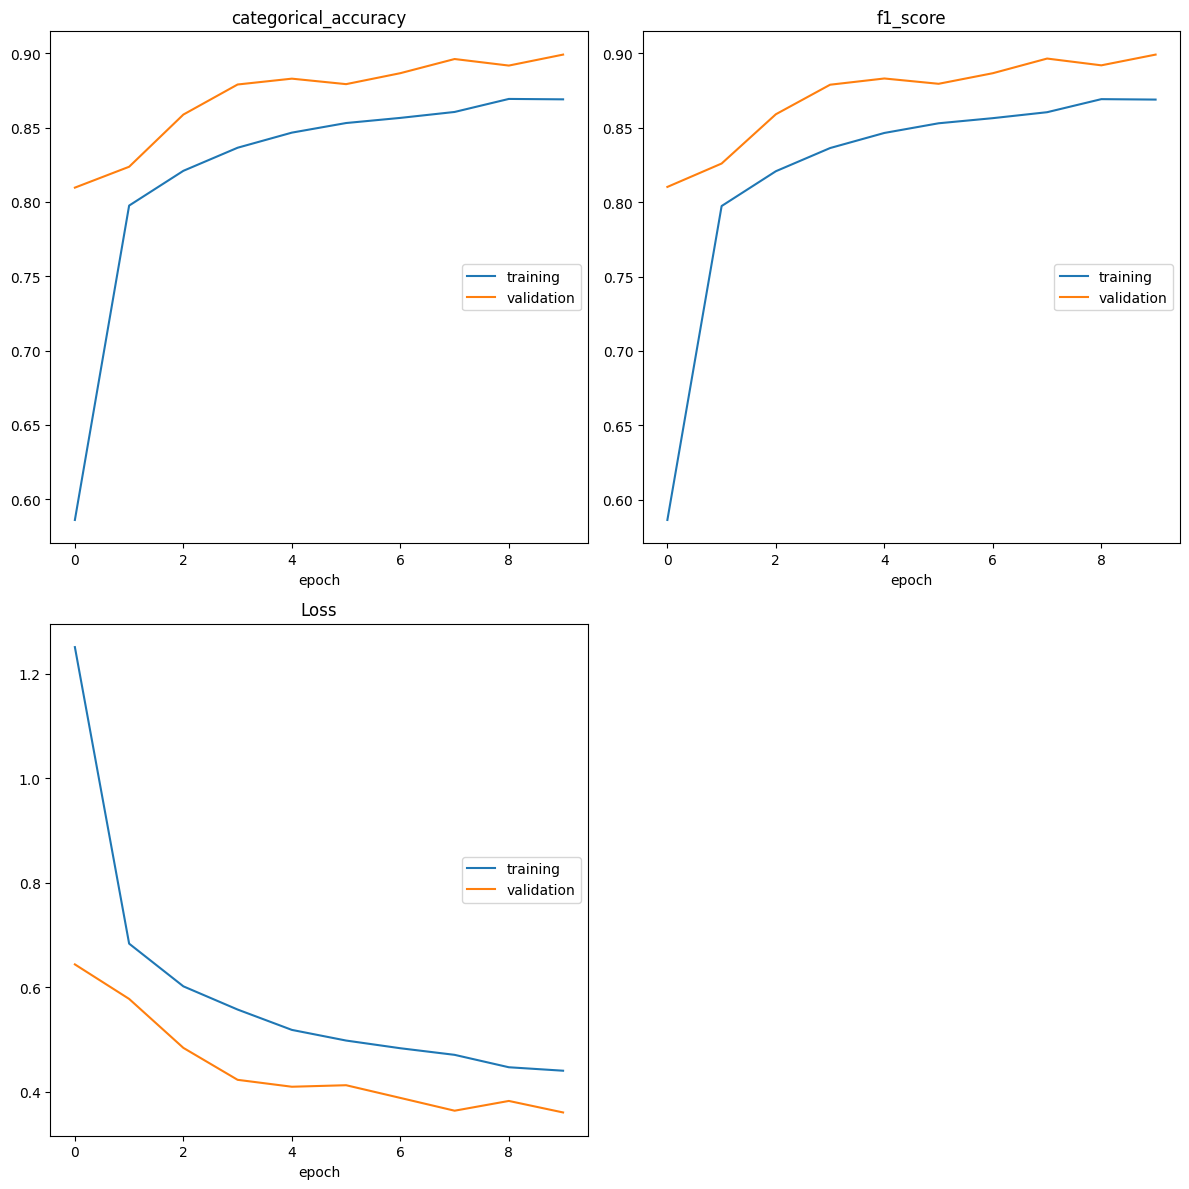

categorical_accuracy
	training         	 (min:    0.586, max:    0.869, cur:    0.869)
	validation       	 (min:    0.810, max:    0.899, cur:    0.899)
f1_score
	training         	 (min:    0.586, max:    0.869, cur:    0.869)
	validation       	 (min:    0.810, max:    0.899, cur:    0.899)
Loss
	training         	 (min:    0.440, max:    1.251, cur:    0.440)
	validation       	 (min:    0.361, max:    0.644, cur:    0.361)
616/616 [==============================] - 851s 1s/step - loss: 0.4404 - categorical_accuracy: 0.8691 - f1_score: 0.8690 - val_loss: 0.3606 - val_categorical_accuracy: 0.8992 - val_f1_score: 0.8992 - lr: 0.0016
Epoch 11/100
162/616 [======>.......................] - ETA: 13:25 - loss: 0.4192 - categorical_accuracy: 0.8784 - f1_score: 0.8783

In [11]:
model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

# Вывод:

Данная модель была практической проверкой регуляризации весов во время обучения.

 Сперва мы обучили модель с параметром kernel_regularizer='l2'

![-](data/kernel_regularizer.jpg)

А потом с bias_regularizer='l2'

![-](data/bias_regularizer.jpg)

По итогу я сделали вывод, что bias_regularizer='l2' делает модель более стабильнее, однако про метрики ничего сказать не могу